In [21]:
%load_ext autoreload
%autoreload 2

import torch
from krxns.config import filepaths
from krxns.ml import load_data, split_data, featurize_data
from chemprop import featurizers
from chemprop.models import multi
from lightning import pytorch as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
def latest_ckpt(ckpt_dir: Path):
    ckpts = list(ckpt_dir.glob("*.ckpt"))
    ckpt_rank = [tuple([elt.split("=")[-1] for elt in ckpt.stem.split("-")]) for ckpt in ckpts]
    srt_ckpts = sorted(zip(ckpt_rank, ckpts), key=lambda x : x[0], reverse=True)
    return srt_ckpts[0][1]

In [ ]:
# Set this
data_dir = filepaths['data'] / "shortest_path_length/sprhea_240310_v3_mapped_top_25_whitelist_atom_lb_20p_multi_nodes_True"
n_chunks = 1
split_idx = 1
log_dir = filepaths["spl_cv"] / "hp_0" / "split_1" / "version_0"
ckpt_dir = log_dir / "checkpoints"

PosixPath('/home/stef/quest_data/krxns/results/spl_cv/hp_0/split_1/version_0/checkpoints/epoch=2-step=210.ckpt')

In [24]:
all_data = load_data(filepaths['data'] / data_dir, n_chunks)
featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer() # TODO: extend to others w/ CL arg selecting
train_data, test_data = split_data(all_data, split_idx)
train_dataloader, scaler = featurize_data(train_data, featurizer, train_mode=True) # Should only shuffle for train dataloader (see chemprop docs)
test_dataloader, _ = featurize_data(test_data, featurizer, train_mode=False)

/home/stef/.cache/pypoetry/virtualenvs/krxns-C4WZyL61-py3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [25]:
ckpt = latest_ckpt(ckpt_dir)
model = multi.MulticomponentMPNN.load_from_checkpoint(ckpt, map_location=torch.device('cpu'))

/home/stef/.cache/pypoetry/virtualenvs/krxns-C4WZyL61-py3.12/lib/python3.12/site-packages/chemprop/models/multi.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torc

In [26]:
with torch.inference_mode():
    trainer = pl.Trainer(
        logger=False,
        enable_progress_bar=True,
        accelerator="auto",
        devices=1
    )
    test_preds = trainer.predict(model, test_dataloader)

test_preds = np.concatenate(test_preds, axis=0)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/stef/.cache/pypoetry/virtualenvs/krxns-C4WZyL61-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [27]:
test_data["y_hat"] = test_preds
test_data.head(20)

,starter_id,target_id,starter_smiles,target_smiles,spl,y_hat
571,1109,1110,CCCCCC=CCC=CCC=CCC=CCCCC(=O)OCC(COP(=O)(O)OP(=...,CCCCCC=CCC=CCC=CCC=CCCCC(=O)OCC(COP(=O)(O)O)OC...,1,2.832515
770,1505,5018,CCCCCCCCC=CCCCCCCCC(=O)OCC(COP(=O)(O)OCCN)OC(=...,CCCCCCCCC=CCCCCCCCC(=O)OC(CO)COP(=O)(O)OCCN,1,7.808733
908,1764,1041,O=CNC(=O)C=CC(=O)O,O=CO,1,4.542248
915,1775,9588,CCCCCCCCC=CCCCCCCCC(=O)O.CCCCCCCCCCCCCCCCCCCC(...,CCCCCC=CC(O)C=CCCCCCCCC(=O)O,6,6.705656
922,1783,10145,CC1Cc2c3c(cc(O)c2C(=O)O1)OC1(C)CCC2C(C)(C)C(=O...,CC1CCC2C1=CC(C)(C)CC1CC12C,6,7.974072
931,1795,956,CCCCCCCCCCCCCCCCCCOCC(O)COP(=O)(O)OCC[N+](C)(C)C,O=C(CO)COP(=O)(O)O,6,9.329337
962,1840,3063,CCCCCCCCC=CCCCCCCCC(=O)OC(COC(=O)CCCCCCCCCCCCC...,O=C(O)C(O)C(O)C(=O)O,6,8.710310
973,1858,6702,CC(C)=CCc1c(O)cc(O)c(C(=O)C=Cc2ccc(O)cc2)c1O,Nc1ncnc2c1ncn2C1OC(CO)C(OP(=O)(O)O)C1O,6,10.061923
974,1862,296,*C(=O)OCC(O)COP(=O)(O)OCCN.CCCCCCCCCCCCCCCC(=O...,Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)OP(=O)(O...,6,7.308279
1009,1931,2475,CC(=O)NC1C(O)OC(CO)C(O)C1O.O=c1ccn(C2OC(COP(=O...,CC(N)C(=O)NC(C)C(=O)O,6,10.079785


<Axes: xlabel='epoch'>

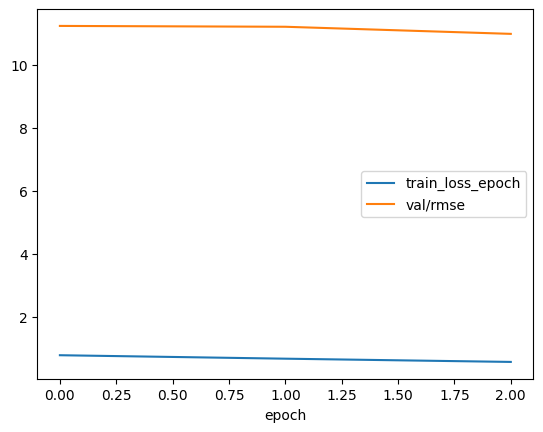

In [ ]:
# Loss curves
lc = pd.read_csv(log_dir / "metrics.csv", sep=',')
ep_ave_lc = lc.groupby('epoch').agg('mean').reset_index() # Average over epochs
ep_ave_lc.head()
ep_ave_lc.plot(x="epoch", y=['train_loss_epoch', 'val/rmse', 'val_loss'])